## Neil Shah: Module 2 DATA 608

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools


# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

import shapely
from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

C:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Question 1
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

# Loading the dataset

I saved the initial data-set to my local computer; originally I was going to try to pull it directly from the Pluto URL--but it was a shocking large size! 

In [ ]:
df = pd.read(FILEPATH)
#FILEPATH is the location on my hard-drive for the file

### Exploratory Data Analysis

Ok let's start looking some basic metrics for this dataset.

In [ ]:
df.info

```
Out[304]: 
<bound method DataFrame.info of        borough  block  ...  dcpedited  notes
0           BK    834  ...        NaN    NaN
1           QN   4042  ...        NaN    NaN
2           BK   4679  ...        NaN    NaN
3           BK   7831  ...        NaN    NaN
4           BK   7831  ...        NaN    NaN
       ...    ...  ...        ...    ...
859167      BX   4656  ...        NaN    NaN
859168      QN   8620  ...        NaN    NaN
859169      BK   2575  ...        NaN    NaN
859170      MN   2023  ...          t    NaN
859171      MN   2059  ...          t    NaN

[859172 rows x 99 columns]>
```

In [ ]:
df.head()

```
  borough  block  ...  dcpedited  notes
0      BK    834  ...        NaN    NaN
1      QN   4042  ...        NaN    NaN
2      BK   4679  ...        NaN    NaN
3      BK   7831  ...        NaN    NaN
4      BK   7831  ...        NaN    NaN
```

In [ ]:
df.columns

```
Out[306]: 
Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healtharea',
       'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2',
       'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2',
       'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse',
       'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea',
       'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea',
       'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront',
       'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode',
       'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1',
       'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar',
       'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord',
       'ycoord', 'latitude', 'longitude', 'zonemap', 'zmcode', 'sanborn',
       'taxmap', 'edesignum', 'appbbl', 'appdate', 'plutomapid', 'version',
       'sanitdistrict', 'healthcenterdistrict', 'firm07_flag', 'pfirm15_flag',
       'rpaddate', 'dcasdate', 'zoningdate', 'landmkdate', 'basempdate',
       'masdate', 'polidate', 'edesigdate', 'geom', 'dcpedited', 'notes'],
      dtype='object')
 ```

In [ ]:
df.dtypes

```
Out[312]: 
borough        object
block           int64
lot             int64
cd            float64
ct2010        float64
  
polidate      float64
edesigdate    float64
geom           object
dcpedited      object
notes         float64
Length: 99, dtype: object
```

In [ ]:
df.head()

```
Out[307]: 
  borough  block  ...  dcpedited  notes
0      BK    834  ...        NaN    NaN
1      QN   4042  ...        NaN    NaN
2      BK   4679  ...        NaN    NaN
3      BK   7831  ...        NaN    NaN
4      BK   7831  ...        NaN    NaN

[5 rows x 99 columns
```

In [ ]:
df.isnull().sum()

```
Out[308]: 
borough            1
block              0
lot                0
cd               986
ct2010           986
 
polidate      859172
edesigdate    859172
geom            1731
dcpedited     819399
notes         858610
Length: 99, dtype: int64
```

This is a large dataset (my poor laptop is struggling)--that has over 800,000 rows, 99 columns, mixed data types and quite a few missing values.

Our first problem involves plotting the height of buildings as a function of time. After consulting [Pluto Docs](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page) and office hours, it seems that the features 'yearbuilt', 'numfloors' and 'numbldgs' might be of interesting. 

Let's start with those


In [ ]:
#I always like to make a copy of the dataframe before munging it.

df1=df[['numbldgs','numfloors','yearbuilt']].copy()

In [ ]:
#Now let's check the NA values within my reduced dataframe
df1.isna().sum()

```
Out[316]: 
numbldgs     843
numfloors    843
yearbuilt    400
dtype: int64
```

Needless to say I don't want to be focused on values that are missing--so I'm going to drop them.

In [ ]:
df1.dropna(inplace=True)
df1.isna().sum()

```
Out[318]: 
numbldgs     0
numfloors    0
yearbuilt    0
dtype: int64
```

Ok now we cleaned all the NA values from out dataset. Let's take a further look at our dataset

In [ ]:
df1.describe()

```
Out[321]: 
            numbldgs      numfloors      yearbuilt
count  858329.000000  858329.000000  858329.000000
mean        1.278835       2.335447    1846.068630
std         2.713995       2.008039     419.250065
min         0.000000       0.000000       0.000000
25%         1.000000       2.000000    1920.000000
50%         1.000000       2.000000    1930.000000
75%         2.000000       2.500000    1955.000000
max      1861.000000     205.000000    2020.000000
```

Well that's strange--we have 0 values for yearbuilt, numfloors and numbldgs? Once again consulting the Pluto doc, if numfloors or numbldgs are 0, that usually refers to missing data. On the year side--we definitely don't need 0. Furthermore, I'm going to go ahead and filter out the numbldgs value that are not 1, since those might refer to condos or other things. The Pluto doc alraedy says that the numfloors refers to the "tallest" building in the lot and that's what we are after

In [ ]:
df1=df1[((df1['numbldgs']==1) & (df1['yearbuilt']!=0) & (df1['numfloors']!=0))]

In [ ]:
df1

```
Out[329]: 
        numbldgs  numfloors  yearbuilt
0            1.0        3.0     1931.0
3            1.0        2.0     1920.0
4            1.0        2.0     1920.0
5            1.0        2.0     1920.0
6            1.0        2.0     1920.0
         ...        ...        ...
859165       1.0        2.0     1920.0
859167       1.0        4.0     1920.0
859169       1.0        3.0     1901.0
859170       1.0        3.0     1891.0
859171       1.0        3.0     1893.0

[581140 rows x 3 columns]
```

Naturally our index is already screwed up due to taking out various rows. I think yearbuilt would make a good index instead but first we have to convert it from a float64 to a datetime.

In [ ]:
df1['yearbuilt']=pd.to_datetime(df1['yearbuilt'], format='%Y', errors='coerce')
df1['yearbuilt']

```
Out[332]: 
0        1931-01-01
3        1920-01-01
4        1920-01-01
5        1920-01-01
6        1920-01-01
   
859165   1920-01-01
859167   1920-01-01
859169   1901-01-01
859170   1891-01-01
859171   1893-01-01
Name: yearbuilt, Length: 581140, dtype: datetime64[ns]
```

There we go--datetime! Naturally there could of been some values that were not converted (NaT)--I'm going to drop them as I have done previously, sort the values and then set the yearbuilt as my time index. 

In [ ]:
df1.dropna(inplace=True)
df1.sort_values(by='yearbuilt',inplace=True)
df1.set_index('yearbuilt',drop=True,inplace=True)
df1

```
Out[340]: 
            numbldgs  numfloors
yearbuilt                      
1694-01-01       1.0       2.00
1719-01-01       1.0       4.00
1720-01-01       1.0       2.75
1722-01-01       1.0       1.50
1725-01-01       1.0       1.75
             ...        ...
2019-01-01       1.0       4.00
2019-01-01       1.0       2.00
2019-01-01       1.0       2.00
2019-01-01       1.0       2.00
2020-01-01       1.0       3.00
[581139 rows x 2 columns]
```

Much better! However you'll notice we still have a large dataset (nearly 600,000 rows). Let's try to plot this to see if we can narrow down the dataset range. I'll resample the dataset by Year and take the total number of buildings built. 

In [ ]:
df1['numbldgs'].resample('Y').sum().plot()
plt.ylabel('Number of Buildings')
plt.title('Total Number of Buildings built by Year')

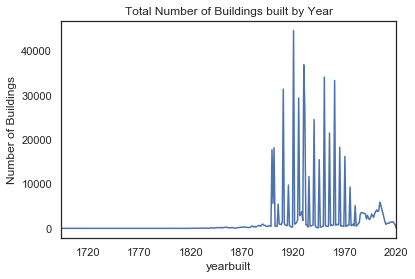

This plot shows us that most of the buildings were built around 1890 and onward--so we'll focus our data on that range. I like to make a helper column for year. 

In [ ]:
df1['Year']=df1.index.year

One great informative visualization plot I can make is a boxplot--which will naturally showthe distribution of the buildings and their corresponding heights. Here is an example for the 2010 onward years.

In [ ]:
df1.loc['2010':].boxplot(column='numfloors',by='Year')
plt.title('Building heights by built year')
plt.grid(b=None)
plt.suptitle("")

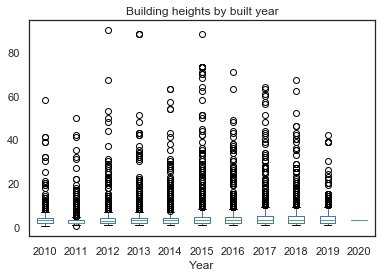

This is an actually a great way to 

In [ ]:
df1.loc['1990':].boxplot(column='numfloors',by='Year')
plt.title('Building heights by built year')
plt.xticks(rotation=90)
plt.grid(b=None)
plt.suptitle("")

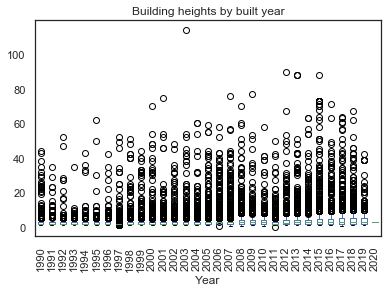

Starting to get a little crowded but you can really see some of the outliers. However if we extend this to the entire time-range--the plot gets pretty messy--I'll show below.

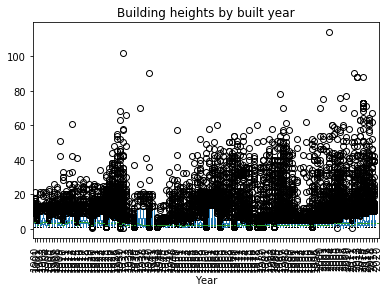

I could modify the plot size and make it cleaner--but instead I'll demonstrate ways to bin the heights. 

In [ ]:
bins=list(range(0,120,10))

I made a vector of bins to capture the height--and using pd.cut (a panda tool to make categorical labels) I can apply this to make a nice table to show the values. Note--I went ahead and dropped 'numbldgs' since they were already all equal to 1--we got no further information from it. 

In [ ]:
table=df1.groupby(['Year', pd.cut(df1['numfloors'], bins)]).size().unstack()
table

```
numfloors  (0, 10]  (10, 20]  (20, 30]  ...  (60, 70]  (70, 80]  (80, 90]
Year                                    ...                              
2000        3764.0      20.0       3.0  ...       1.0       NaN       NaN
2001        4144.0      22.0       3.0  ...       NaN       1.0       NaN
2002        3761.0      14.0       7.0  ...       NaN       NaN       NaN
2003        3963.0      22.0       5.0  ...       NaN       NaN       NaN
2004        5835.0      20.0       5.0  ...       NaN       NaN       NaN
2005        5203.0      47.0      10.0  ...       NaN       NaN       NaN
2006        4150.0      44.0      16.0  ...       NaN       NaN       NaN
2007        3336.0      53.0      19.0  ...       NaN       1.0       NaN
2008        2386.0      57.0      10.0  ...       1.0       NaN       NaN
2009        1431.0      26.0       3.0  ...       NaN       1.0       NaN
2010         850.0      26.0       3.0  ...       NaN       NaN       NaN
2011        1100.0      22.0       3.0  ...       NaN       NaN       NaN
2012        1119.0      33.0      15.0  ...       1.0       NaN       1.0
2013        1065.0      37.0       8.0  ...       NaN       NaN       3.0
2014        1323.0      45.0      13.0  ...       2.0       NaN       NaN
2015        1368.0      50.0      17.0  ...       5.0       9.0       1.0
2016        1279.0      53.0      23.0  ...       1.0       1.0       NaN
2017        1374.0      56.0      20.0  ...       3.0       NaN       NaN
2018        1039.0      57.0      15.0  ...       2.0       NaN       NaN
2019         685.0      35.0       5.0  ...       NaN       NaN       NaN
2020           1.0       NaN       NaN  ...       NaN       NaN       NaN
```

Here we succicntly created a table that binned all the building heights across years! From here I have a few options. I could go ahead and just plot this all--but notice that first bin (0,10] really dominates the data. I could just avoid plotting it since logically if we are concerened about collapses, those aren't necessary. 

I can now plot the data-set in various ways to visualize it: 

In [ ]:
table.iloc[-100:,2:].plot.bar(stacked=True,figsize=(15,3),title='Binned Building Heights by year')

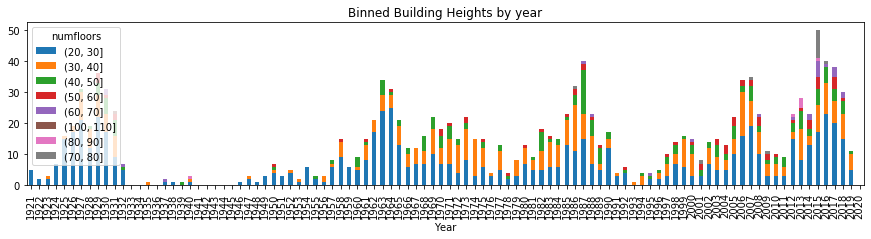

In [ ]:
table.iloc[-100:,2:].plot(title='Binned Heights by Year Built')

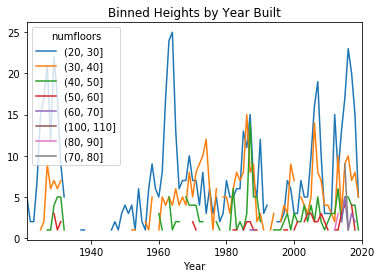

Using seaborn I can take the table and make a heatmap

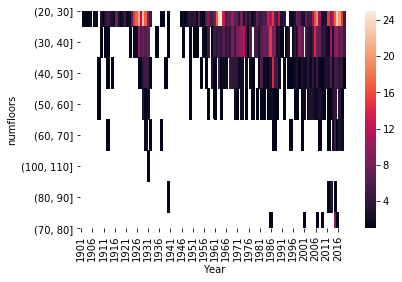

We can do an area plot as well

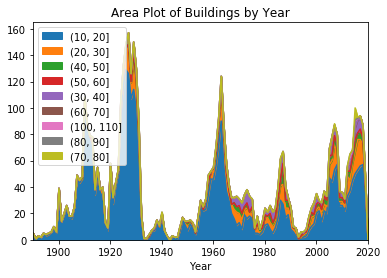

Great--I have shown various ways to visualize the heights of NYC buildings over time. 

### Question 2

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

From our exploratory data analysis, I picked longitude, latitude assessmentotal and assessmentland as our features. Once again I'll make a new copy to avoid messing the original dataframe.

In [2]:
#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [ ]:
df2=df[['latitude','longitude','assessland','assesstot']].copy()

In [ ]:
df2.head()

```
Out[9]: 
    latitude  longitude  assessland  assesstot
0  40.637972 -74.007347    146250.0   350550.0
1  40.786562 -73.846003     12240.0    78900.0
2  40.653216 -73.926923     18120.0    34380.0
3  40.623876 -73.925958      7680.0    24600.0
4  40.623874 -73.926030      8160.0    29760.0
```

In [ ]:
df2.isnull().sum()

```
Out[11]: 
latitude      1085
longitude     1085
assessland     400
assesstot      400
dtype: int64
```

Once again let's do our usual munging and elimination of 0 values.

In [ ]:
df2.dropna(axis=0,inplace=True)
df2=df2[((df2['assesstot']!=0) & (df2['assessland']!=0))]

Looks like we have latitude/longitude data as well as assessment data. Let's delve deeper into the assesstot and assessland statistics.

In [ ]:
df2[['assesstot','assessland']].describe()

```
      assesstot    assessland
count  8.576870e+05  8.576870e+05
mean   5.211157e+05  1.233993e+05
std    1.132812e+07  5.517513e+06
min    0.000000e+00  0.000000e+00
25%    3.468000e+04  1.026000e+04
50%    5.076000e+04  1.422000e+04
75%    9.120000e+04  2.250000e+04
max    7.135741e+09  3.211276e+09
```

The purpose of a bivariate chloropleth graph is to show the relationship between two variables, in this case assesstot and assessland, and see if there is a correlation of them individually and together, as a proxy for build status in NYC.

First--let's bin these two categories--I'm going to make 3 bins for each of them (giving us a total of 9 combinations) and assign labels to make it easier to color. The beauty of pd.qcut is that it'll make 3 bins for me (by percentile) and explicty show label hierachy.

In [ ]:
df2['AssessTotalBins']=pd.qcut(df2['assesstot'],q=3,labels=['A1','A2','A3'])
df2['AssessLandBins']=pd.qcut(df2['assessland'],q=3,labels=['B1','B2','B3'])

With the labels, it implies A1 < A2 < A3 and B1 < B2 < B3

I'm now going to make a new a new column called "Marker" which will be the combination of each entry's label for Assesstotal and Assessland based on bins. I will first convert the labels to strings and then save "Marker" as a categorical label. 

In [ ]:
df2['Marker']=df2['AssessTotalBins'].astype(str)+df2['AssessLandBins'].astype(str)
df2['Marker'] = pd.Categorical(df2['Marker'])
df2.head()

```
    latitude  longitude  assesstot  ...  AssessTotalBins AssessLandBins Marker
0  40.637972 -74.007347   350550.0  ...               A3             B3   A3B3
1  40.786562 -73.846003    78900.0  ...               A3             B2   A3B2
2  40.653216 -73.926923    34380.0  ...               A1             B2   A1B2
3  40.623876 -73.925958    24600.0  ...               A1             B1   A1B1
4  40.623874 -73.926030    29760.0  ...               A1             B1   A1B1
```

Great--we now have Markers (9 total combinations) with labels. 

Now the final step is to find a color scheme to map our As/Bs to--using the documentation from https://rpubs.com/josezuniga/359867, I chose to use the 2nd color pallete. 

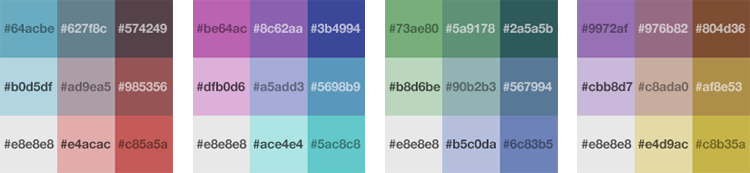

In [ ]:
colors = {'A3B1': '#be64ac', 'A3B2': '#8c62aa', 'A3B3': '#3b4994', 
          'A2B1': '#dfb0d6', 'A2B2': '#a5add3', 'A2B3': '#5698b6', 
          'A1B1': '#e8e8e8', 'A1B2': '#ace4e4', 'A1B3': '#5ac8c8'}

Awesome--now we have mapped out (color) wise our A (Assessed Total) and B(Assessed Land) values, and since 1 < 2 < 3 (for both A's and Bs), and based on our color scheme we can visualize the nominal value per entry for these two categories. 

In [ ]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(df2, 'longitude', 'latitude', ds.count_cat('Marker'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

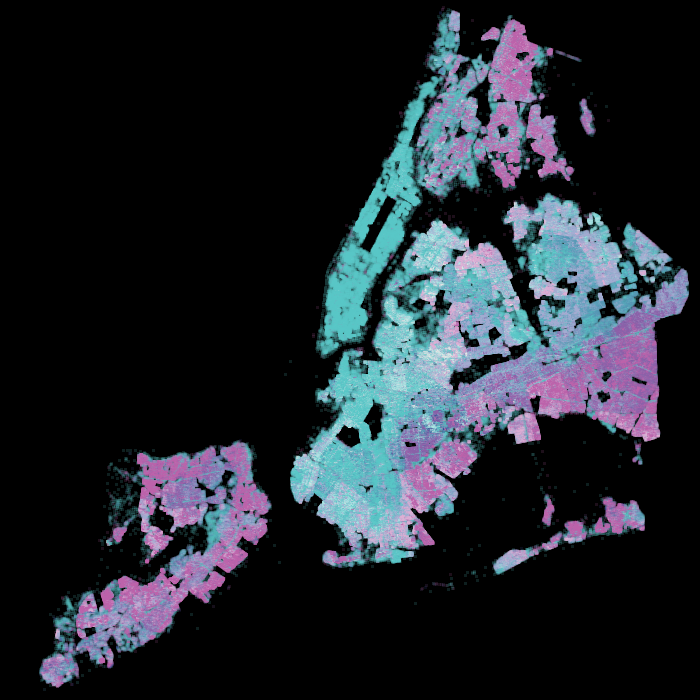

Based on the map Manhattan is all dark blue indicating maximum assessland/assessedtotal--that doesn't suprise me given the lack of land, the population and how popular Manhattan is. Brooklyn also has dark blue in the more populated areas. Staten Island and parts of east Brooklyn have lower assessed values, while Queens/Bronx have some in between. 